In [32]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("shantanudhakadd/bank-customer-churn-prediction")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'bank-customer-churn-prediction' dataset.
Path to dataset files: /kaggle/input/bank-customer-churn-prediction


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_recall_curve,accuracy_score

from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier


In [34]:
df = pd.read_csv("/kaggle/input/bank-customer-churn-prediction/Churn_Modelling.csv")
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [35]:

# Add engineered features
df['Balance_to_Salary'] = df['Balance'] / (df['EstimatedSalary'] + 1)
df['Tenure_to_Age'] = df['Tenure'] / df['Age']
df['Product_Utilization'] = df['NumOfProducts'] / (df['Tenure'] + 1)
df['Active_Credit_User'] = df['IsActiveMember'] * df['HasCrCard']
df['High_Value'] = (df['Balance'] > df['Balance'].median()).astype(int)
df['Credit_Age'] = df['CreditScore'] * df['Age']

# Age groups
df['Age_Group'] = pd.cut(df['Age'], bins=[18, 30, 40, 50, 60, 100],
                         labels=['18–30', '31–40', '41–50', '51–60', '60+'])

# Target encoding for Geography
geo_churn_rate = df.groupby('Geography')['Exited'].mean()
df['Geo_Churn_Rate'] = df['Geography'].map(geo_churn_rate)

df.head()


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,...,EstimatedSalary,Exited,Balance_to_Salary,Tenure_to_Age,Product_Utilization,Active_Credit_User,High_Value,Credit_Age,Age_Group,Geo_Churn_Rate
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,...,101348.88,1,0.000000,0.047619,0.333333,1,0,25998,41–50,0.161548
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,...,112542.58,0,0.744670,0.024390,0.500000,0,0,24928,41–50,0.166734
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,...,113931.57,1,1.401362,0.190476,0.333333,0,1,21084,41–50,0.161548
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,...,93826.63,0,0.000000,0.025641,1.000000,0,0,27261,31–40,0.161548
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,...,79084.10,0,1.587035,0.046512,0.333333,1,1,36550,41–50,0.166734


In [36]:
selected_features = [
    'CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary',
    'IsActiveMember', 'Balance_to_Salary', 'Tenure_to_Age', 'Product_Utilization',
    'Active_Credit_User', 'High_Value', 'Credit_Age', 'Geo_Churn_Rate'
]


X = df[selected_features]
y = df['Exited']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [46]:
smote = SMOTE(sampling_strategy=0.5, k_neighbors=5, random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test)

In [49]:


# Define parameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],     # Regularization strength (inverse)
    'penalty': ['l1', 'l2'],          # Type of regularization
    'solver': ['liblinear', 'saga']   # Solvers that support both L1 & L2
}

# Initialize model
lr = LogisticRegression(random_state=42, max_iter=1000, class_weight={0:25,1:5})

# Grid search with 5-fold cross-validation
grid_search = GridSearchCV(
    estimator=lr,
    param_grid=param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

# Fit on training data
grid_search.fit(X_train_scaled, y_train_res)

# Best parameters and model
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Accuracy:", grid_search.best_score_)

# Evaluate on test set
best_lr = grid_search.best_estimator_
y_pred = best_lr.predict(X_test_scaled)


print("\nTest Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Parameters: {'C': 1, 'penalty': 'l1', 'solver': 'saga'}
Best Cross-Validation Accuracy: 0.14581804973069595

Test Accuracy: 0.805

Confusion Matrix:
 [[1590    3]
 [ 387   20]]

Classification Report:
               precision    recall  f1-score   support

           0       0.80      1.00      0.89      1593
           1       0.87      0.05      0.09       407

    accuracy                           0.81      2000
   macro avg       0.84      0.52      0.49      2000
weighted avg       0.82      0.81      0.73      2000



In [52]:


# Define the Decision Tree with class balancing
dt = DecisionTreeClassifier(random_state=42, class_weight={0:50,1:1})

# Set the hyperparameter grid
param_grid = {
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 5, 10]
}

# Apply GridSearchCV
grid = GridSearchCV(dt, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid.fit(X_train_scaled, y_train_res)  # Use your preprocessed training set

# Best model
best_dt = grid.best_estimator_
print("Best parameters:", grid.best_params_)

# Evaluate on test set
y_pred = best_dt.predict(X_test_scaled)  # Use your preprocessed test set
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Best parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Confusion Matrix:
 [[1322  271]
 [ 164  243]]

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.83      0.86      1593
           1       0.47      0.60      0.53       407

    accuracy                           0.78      2000
   macro avg       0.68      0.71      0.69      2000
weighted avg       0.80      0.78      0.79      2000



In [55]:


# Initialize XGBoost
xgb = XGBClassifier(
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss',
    scale_pos_weight=(len(y_train_res[y_train_res==0]) / len(y_train_res[y_train_res==1]))
)

# Define parameter distribution for RandomizedSearch
param_dist = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3],
    'reg_alpha': [0, 0.01, 0.1, 1],
    'reg_lambda': [1, 1.5, 2, 3]
}

# RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=50,            # number of parameter settings sampled
    scoring='f1',
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Fit on training data
random_search.fit(X_train_scaled, y_train_res)

# Best model
best_xgb = random_search.best_estimator_
print("Best parameters:", random_search.best_params_)

# Predict on test set
y_pred = best_xgb.predict(X_test_scaled)

# Evaluate
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Fitting 5 folds for each of 50 candidates, totalling 250 fits


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [12:49:49] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best parameters: {'subsample': 0.9, 'reg_lambda': 2, 'reg_alpha': 0.1, 'n_estimators': 400, 'max_depth': 9, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.7}
Confusion Matrix:
 [[1461  132]
 [ 189  218]]

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.92      0.90      1593
           1       0.62      0.54      0.58       407

    accuracy                           0.84      2000
   macro avg       0.75      0.73      0.74      2000
weighted avg       0.83      0.84      0.83      2000



In [56]:


# Get predicted probabilities for class 1
y_prob = best_xgb.predict_proba(X_test_scaled)[:, 1]

# Find the threshold that maximizes F1
thresholds = np.linspace(0.1, 0.9, 81)
f1_scores = []

for t in thresholds:
    y_pred_thresh = (y_prob >= t).astype(int)
    f1 = f1_score(y_test, y_pred_thresh)
    f1_scores.append(f1)

best_thresh = thresholds[np.argmax(f1_scores)]
print("Best threshold for F1:", best_thresh)

# Apply the best threshold
y_pred_best = (y_prob >= best_thresh).astype(int)

# Evaluate
from sklearn.metrics import classification_report, confusion_matrix
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_best))
print("\nClassification Report:\n", classification_report(y_test, y_pred_best))


Best threshold for F1: 0.41000000000000003
Confusion Matrix:
 [[1420  173]
 [ 162  245]]

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.89      0.89      1593
           1       0.59      0.60      0.59       407

    accuracy                           0.83      2000
   macro avg       0.74      0.75      0.74      2000
weighted avg       0.83      0.83      0.83      2000



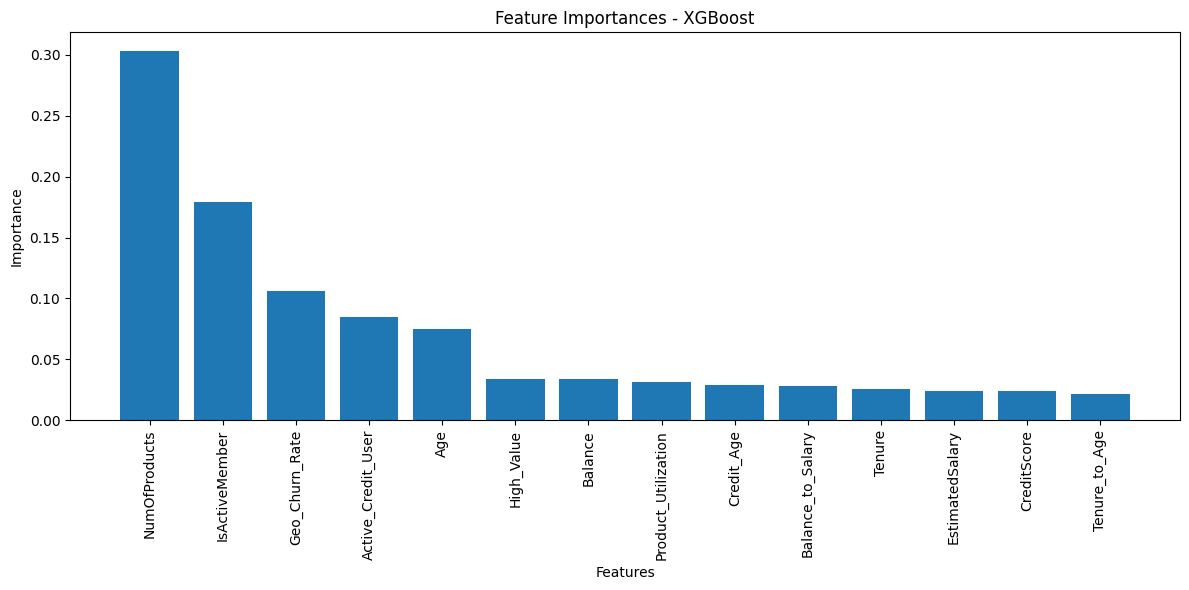

In [67]:


# Get feature importances
importances = best_xgb.feature_importances_
features = X_train.columns  # or the list of your feature names

# Sort features by importance
indices = np.argsort(importances)[::-1]

# Plot
plt.figure(figsize=(12,6))
plt.title("Feature Importances - XGBoost")
plt.bar(range(len(importances)), importances[indices], align='center')
plt.xticks(range(len(importances)), [features[i] for i in indices], rotation=90)
plt.ylabel("Importance")
plt.xlabel("Features")
plt.tight_layout()
plt.show()


In [63]:


# Initialize Gradient Boosting
gbc = GradientBoostingClassifier(random_state=42)

# Define hyperparameter grid
param_grid = {
    'n_estimators': [100, 200,],
    'learning_rate': [0.01, 0.05,],
    'max_depth': [3, 5],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2 ],
    'subsample': [0.5,0.8,1]
}

# Apply GridSearchCV
grid = GridSearchCV(
    estimator=gbc,
    param_grid=param_grid,
    cv=5,
    scoring='f1',     # use F1 to balance precision/recall
    n_jobs=-1,
    verbose=1
)

# Fit on training data
grid.fit(X_train_scaled, y_train_res)  # X_train_scaled and y_train_res are preprocessed

# Best model
best_gbc = grid.best_estimator_
print("Best parameters:", grid.best_params_)

# Predict on test set
y_pred = best_gbc.predict(X_test_scaled)

# Evaluate
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Fitting 5 folds for each of 96 candidates, totalling 480 fits
Best parameters: {'learning_rate': 0.05, 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200, 'subsample': 0.8}
Confusion Matrix:
 [[1508   85]
 [ 193  214]]

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.95      0.92      1593
           1       0.72      0.53      0.61       407

    accuracy                           0.86      2000
   macro avg       0.80      0.74      0.76      2000
weighted avg       0.85      0.86      0.85      2000

